# Market Trend Analysis

Random hodgepodge of analysis using yahoo finance api

In [1]:
'''
Refer to https://pypi.org/project/yfinance/ for some form of documentation
'''
import yfinance as yf
from pytz import timezone
import numpy as np


In [2]:
from datetime import datetime, timedelta

def convert_dt_to_epoch(x):
    # converting the New York (UTC-5) to epoch
    # have to do some manipulation by using a 'wrong' conversion and compensating it
    x = x.replace(tzinfo = timezone('GMT')) # timezone changes, but time itself doesnt
    x = (x - datetime(1970,1,1,tzinfo=timezone('GMT'))).total_seconds() # as epoch
    x = x + 5*60*60 # compensating the time difference 
    return x
# data['Epoch'] = data.Datetime.map(convert_dt_to_epoch)

def midpoint_imputation(vals):
    # impute missing data with the midpoint of the two neighboring values
    # input expects a numpy array of shape (n,)
    # drop leading and tailing nans
    # if there are multiple na's in a row, impute the same midpoint for all
    edges = np.where(~np.isnan(vals))[0][[0,-1]]
    vals = vals[edges[0]:(edges[1]+1)]
    na_inds = np.where(np.isnan(vals))[0]
    for i in na_inds:
        if ~np.isnan(vals[i]):
            pass
        else:
            left = 1; right = 1
            while np.isnan(vals[i-left]):
                left += 1
            while np.isnan(vals[i+right]):
                right += 1
            vals[(i-left+1):(i+right)] = np.mean([vals[i-left],vals[i+right]])
    return vals

## Initialization

In [3]:
ticker = yf.Ticker("ZM")
# data = ticker.history(period = '1mo',
#                    interval = '15m').reset_index()
start_date = str((datetime.now() - timedelta(days=59)).date())
data = ticker.history(interval = '30m', start = start_date).reset_index()

In [3]:
ticker = 'SPWR'
period = '1mo'
interval = '30m'
data = yf.download(tickers = ticker, 
    period = period, interval = interval, group_by = 'ticker', prepost = True).reset_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
symbols = "AAPL,TWTR,MGM,MSFT,NIO,PLUG,PLTR".split(',')
interval = '30m'
tickers = ' '.join(symbols)
start_date = str((datetime.now() - timedelta(days=59)).date())
data = yf.download(tickers = tickers, 
    start = start_date, interval = interval, group_by = 'ticker')

In [ ]:
data['MSFT'].copy().reset_index()

In [4]:
data['Upper'] = data[['Open','Close']].max(axis = 1)
data['Lower'] = data[['Open','Close']].min(axis = 1)
data['Midpoint'] = data[['Open','Close']].mean(axis = 1)

In [5]:
vals = data['Datetime']
v1 = vals.iloc[1:]
v2 = vals.iloc[:-1]
vals = list(map(lambda i: (v1.iloc[i]-v2.iloc[i]).total_seconds() / 60. / 60., range(len(v1))))
vals = [0] + vals
data['New Day'] = list(map(lambda x: x > 0.25, vals))

In [6]:
data['pos'] = data['Datetime'].map(lambda x: (x - data['Datetime'].iloc[0]).total_seconds() / 60 / 60) # for linear regression

## Calculating Epsilon

Calculate a linear regression line, and measure the difference between true price and predicted price

In [ ]:
# linear regression line
# upper/lower linear regression line
# intersection (if any)
# 

In [7]:
from sklearn.linear_model import LinearRegression

def simple_lr(x,y):
    lr = LinearRegression(n_jobs = -1)
    lr.fit(x,y)
    
    return lr, lr.coef_[0], lr.intercept_



In [8]:
x = data['pos']
lr1, m, b = simple_lr(np.array(x).reshape(-1, 1), data['Midpoint'])

In [ ]:
m,b

In [9]:
pred = lr1.predict(np.array(x).reshape(-1,1)) 
data['prop_dist_1'] = (pred - data['Midpoint']).abs() / pred

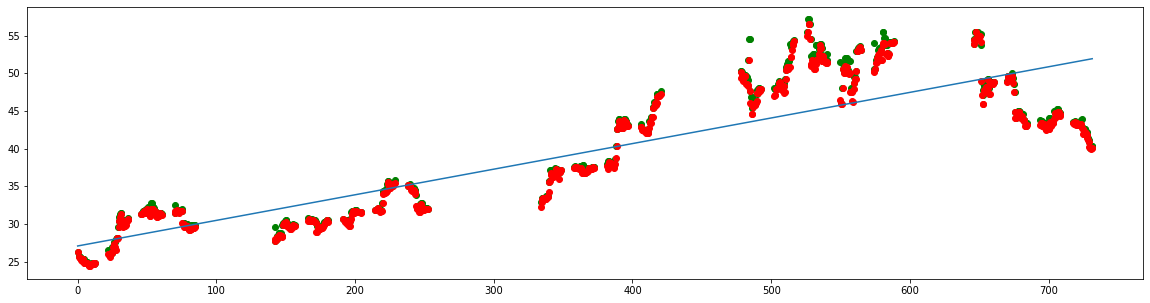

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = [20,5])

y1 = data['Upper'].values
y2 = data['Lower'].values

plt.scatter(x,y1,c='g')
plt.scatter(x,y2,c='r')
plt.plot(x, pred)

plt.show()

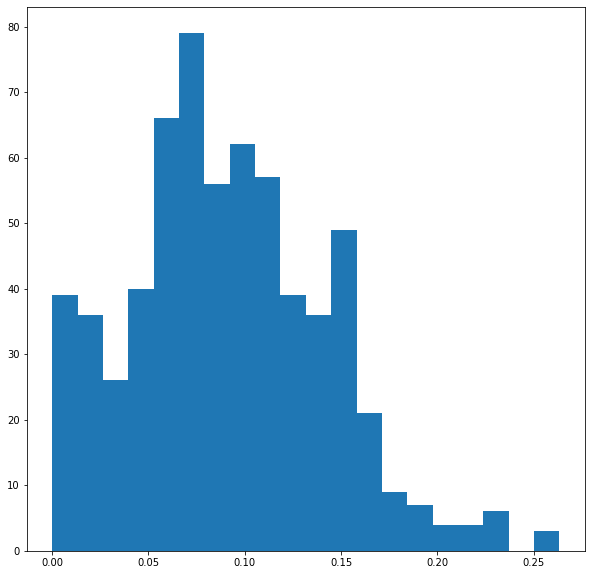

In [11]:
plt.figure(figsize = [10,10])
plt.hist(data['prop_dist_1'], bins = 20)
plt.show()

In [12]:
cutoff = np.percentile(data['prop_dist_1'], 65)
cutoff2 = np.percentile(data['prop_dist_1'], 50)
df = data[data['prop_dist_1'] < cutoff].copy()

In [13]:
x = np.array(df['pos']).reshape(-1,1)
lr2, m, b = simple_lr(x, df['Midpoint'])

In [14]:
pred = lr2.predict(np.array(x).reshape(-1,1))
df['prop_dist_2'] = (pred - df['Midpoint']).abs() / df['Midpoint']

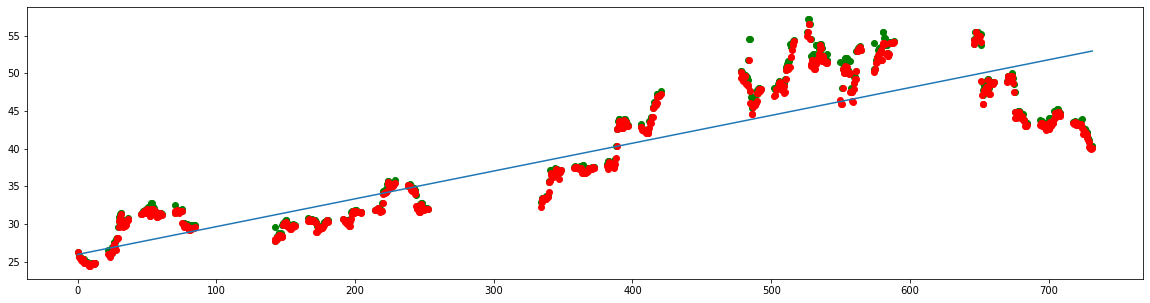

In [15]:
plt.figure(figsize = [20,5])

x = data['pos']
y1 = data['Upper'].values
y2 = data['Lower'].values

plt.scatter(x,y1,c='g')
plt.scatter(x,y2,c='r')
plt.plot(x, lr2.predict(np.array(x).reshape(-1,1)))
plt.show()

In [16]:
df2 = df[df['prop_dist_2'] < cutoff2].copy()
x = np.array(df2['pos']).reshape(-1,1)
lr3, m3, b3 = simple_lr(x, df2['Midpoint'])

In [17]:
df.shape, df2.shape

((415, 14), (333, 14))

In [18]:
pred = lr3.predict(data['pos'].values.reshape(-1,1))
data['epsilon'] = data['Midpoint'] - pred

In [ ]:
import plotly.graph_objects as go

from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=data['Datetime'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
y_trace = lr3.predict(data['pos'].values.reshape(-1,1))
fig.add_trace(go.Scatter(x=data['Datetime'], y=y_trace,
                    mode='lines',
                    name='lines'))
fig.show()

## Calculate RSI and MACD

In [19]:
def calculate_rsi(val, prevU = 0, prevD = 0, n = 9):
    if val > 0:
        avgU = (prevU*(n-1) + val) / n
        avgD = prevD*((n-1)/n)
    else:
        avgU = prevU*((n-1)/n)
        avgD = (prevD*(n-1) - val) / n

    rs = avgU / (avgD + 1e-5)
    rsi = 100.0 - 100.0 / (1 + rs)
    return rsi, avgU, avgD

rsi_list = []
n = 14
rows = data['Close'].values
rows = midpoint_imputation(rows)
# print(rows[-5:])
rows = rows[1:] - rows[:-1] # make prices to deltas

# initial calculation
vals = rows[:n]
prevU = np.sum(vals * (vals > 0).astype(int)) / n
prevD = -1 * np.sum(vals * (vals < 0).astype(int)) / n

for i in range(n, len(rows)):
    rsi, prevU, prevD = calculate_rsi(rows[i], prevU, prevD, n)
    rsi_list.append(rsi)

# modify shape to match indices with original data
rsi_list_modified = [np.nan] * (data.shape[0] - len(rsi_list)) + rsi_list
rsi = np.array(rsi_list_modified)


In [20]:
def calculate_ema(new_val, last_ema, interval, smoothing):
    x = new_val*(smoothing / (1 + interval)) + last_ema*(1-(smoothing / (1 + interval)))
    return x

def calculate_macd(val, last_long_ema, last_short_ema,
                   long_int = 26, short_int = 12, smoothing = 2):
    
    long_ema = calculate_ema(val, last_long_ema, long_int, smoothing)
    short_ema = calculate_ema(val, last_short_ema, short_int, smoothing)
    macd = short_ema - long_ema
    return macd, long_ema, short_ema


# initialize 
vals = data['Close'].values
vals = midpoint_imputation(vals)
smoothing = 2
long_int = 26; short_int = 12 # accepted norm of ema lengths for macd
long_ema = np.mean(vals[:long_int]) # simple average of first 26 values
short_ema = np.mean(vals[(long_int - short_int):long_int]) # simple average of last 12 values from 26th index
macd_list = []

# measure macd
for i in range(long_int, len(vals)):
    macd, long_ema, short_ema = calculate_macd(vals[i], long_ema, short_ema, long_int, short_int, smoothing)
    macd_list.append(macd)

# measure signal line 
int_len = 9
vals = np.array(macd_list)
ema = np.mean(vals[:int_len]) # starting ema is simple average
ema_list = [ema]

for i in range(int_len, len(vals)):
    ema = calculate_ema(vals[i], ema, int_len, smoothing)
    ema_list.append(ema)
    
# modify shape to match indices with original data
macd_list_modified = [np.nan] * (data.shape[0] - len(macd_list)) + macd_list
macd = np.array(macd_list_modified)
ema_list_modified = [np.nan] * (data.shape[0] - len(ema_list)) + ema_list
ema = np.array(ema_list_modified)

In [21]:
too_hot = macd > ema
too_hot = ['r' if x == True else 'g' for x in too_hot]

In [22]:
macd_dist = ema - macd # positive is good to buy (in general)


In [23]:
new_day_color = data['New Day'].map(lambda x: 'r' if x == True else 'b').values

In [24]:
len(new_day_color)

639

In [25]:
data['RSI'] = rsi
data['MACD'] = macd
data['Signal Line'] = ema
data['MACD Distance'] = macd_dist

In [26]:
def day_to_color(x):
    if x == 0:
        return 'g'
    elif x == 2:
        return 'y'
    elif x == 4:
        return 'r'
    else:
        return 'b'
    
weekdays = data['Datetime'].map(lambda x: day_to_color(x.weekday()))

In [27]:
def categorize_trend(x, high_val, low_val, as_color = False):
    if x >= high_val:
        if as_color:
            return 'g'
        else:
            return 'high'
    elif x <= low_val:
        if as_color:
            return 'r'
        else:
            return 'low'
    else:
        if as_color:
            return 'y'
        else:
            return 'normal'

    
data['MACD_category'] = data['MACD'].map(lambda x: categorize_trend(x,2,-2))
data['RSI_category'] = data['RSI'].map(lambda x: categorize_trend(x,70,30))
data['Epsilon_category'] = data['epsilon'].map(lambda x: categorize_trend(x,2,-2))

## Visuals

In [55]:
from collections import Counter

macd_rsi_group = data[['MACD_category','RSI_category']].sum(axis = 1)
counter_dict = Counter(macd_rsi_group)

In [56]:
counter_dict

Counter({'normalnormal': 374,
         'highnormal': 137,
         'lownormal': 82,
         'normallow': 6,
         'lowlow': 15,
         'highhigh': 19,
         'normalhigh': 1})

In [57]:
group_colors = dict(zip(counter_dict.keys(),['y','m','b','r','k','c','g']))
macd_rsi_colors = list(map(lambda x: group_colors[x], macd_rsi_group))


In [58]:
counter_dict

Counter({'normalnormal': 374,
         'highnormal': 137,
         'lownormal': 82,
         'normallow': 6,
         'lowlow': 15,
         'highhigh': 19,
         'normalhigh': 1})

{
  "normalnormal": "y",
  "highnormal": "m",
  "lownormal": "b",
  "normallow": "r",
  "lowlow": "k",
  "highhigh": "c",
  "normalhigh": "g"
}


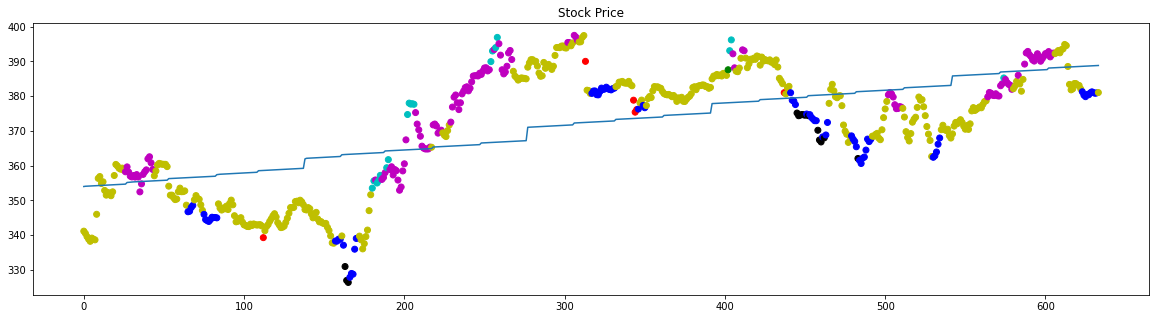

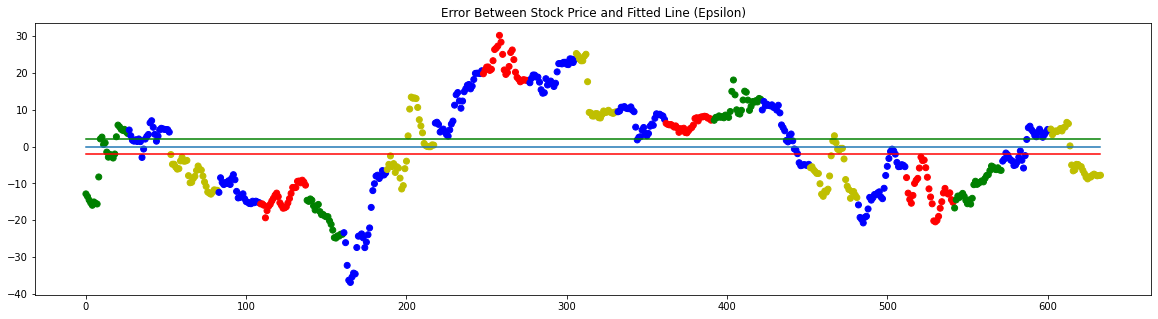

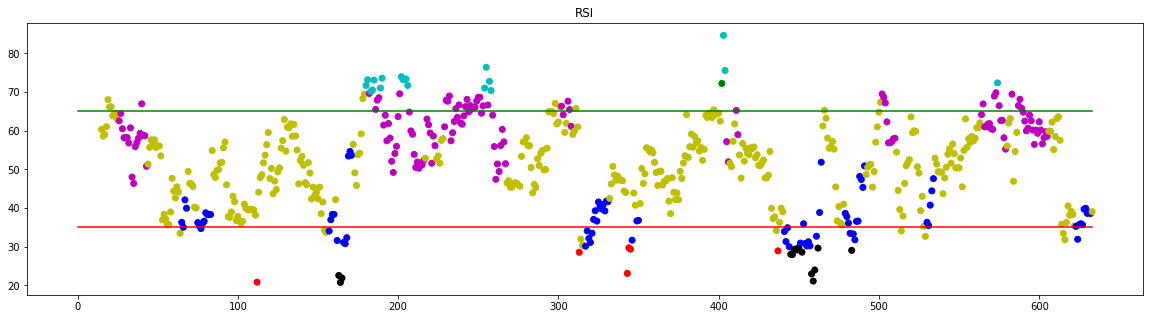

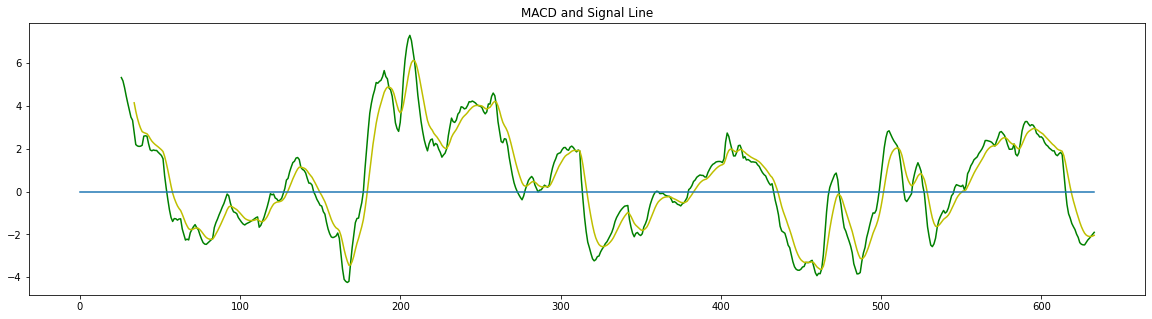

In [59]:
import json
print(json.dumps(group_colors, indent = 2))

pred = lr3.predict(np.array(x).reshape(-1,1))
l = 20; h = 5
plt.figure(figsize = [l,h])

# x = data['pos'] # to separate out time between days
x = range(data.shape[0]) # smoothed out 
# y1 = data['Upper'].values
# y2 = data['Lower'].values
y1 = data['Midpoint'].values
pred = lr3.predict(np.array(data['pos']).reshape(-1,1))

# plt.scatter(x,y1,c='g')
# plt.scatter(x,y2,c='r')
plt.scatter(x,y1, c = macd_rsi_colors)
plt.plot(x, pred)
plt.title('Stock Price')
plt.show()

plt.figure(figsize = [l,h])
y = data['epsilon'].values
plt.scatter(x,y, c = weekdays)
plt.plot(x,[0]*len(x))
plt.plot(x,[2]*len(x),c='g')
plt.plot(x,[-2]*len(x),c='r')
plt.title('Error Between Stock Price and Fitted Line (Epsilon)')
plt.show()

plt.figure(figsize = [l,h])
y2 = data['RSI'].values
plt.scatter(x,y2, c = macd_rsi_colors)
plt.plot(x,[65]*len(x), c='g')
plt.plot(x,[35]*len(x), c='r')
plt.title('RSI')
plt.show()

plt.figure(figsize = [l,h])
y3 = data['MACD'].values
y4 = data['Signal Line'].values
plt.plot(x,y3,c='g')
plt.plot(x,y4,c='y')
plt.plot(x,[0]*len(x))
plt.title('MACD and Signal Line')
plt.show()

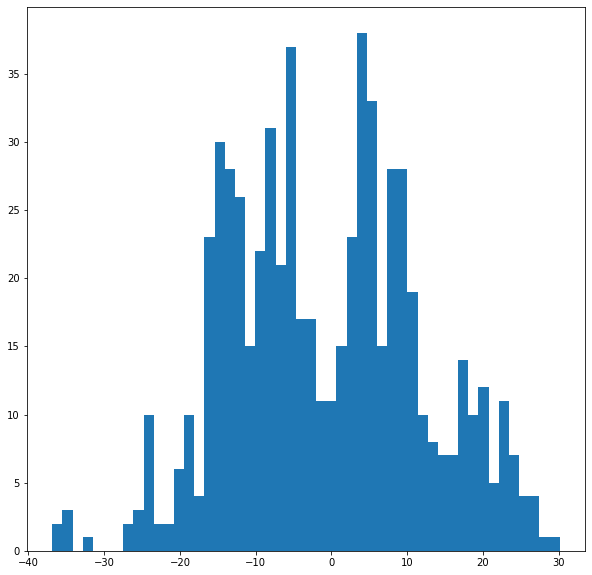

In [60]:
vals = data['epsilon'].values
vals = vals[~np.isnan(vals)]
plt.figure(figsize = [10,10])
plt.hist(vals, bins = 50)
plt.show()


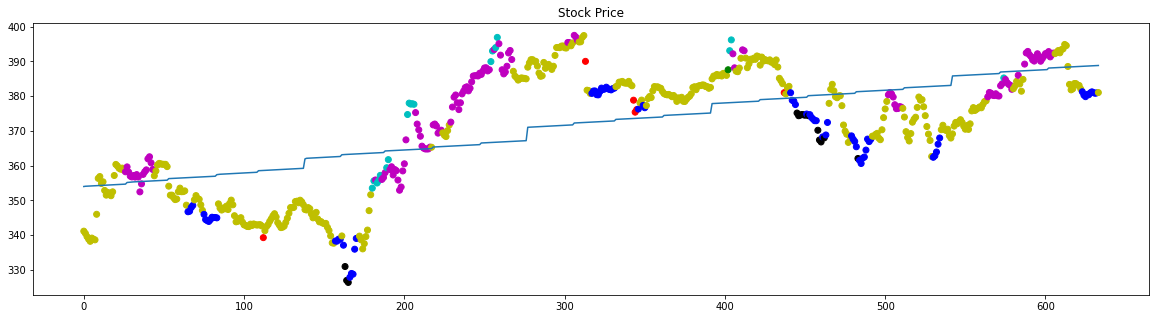

In [61]:
pred = lr3.predict(np.array(x).reshape(-1,1))
plt.figure(figsize = [20,5])

# x = data['pos'] # to separate out time between days
x = range(data.shape[0]) # smoothed out 
# y1 = data['Upper'].values
# y2 = data['Lower'].values
y1 = data['Midpoint'].values
pred = lr3.predict(np.array(data['pos']).reshape(-1,1))

# plt.scatter(x,y1,c='g')
# plt.scatter(x,y2,c='r')
plt.scatter(x,y1, c = macd_rsi_colors)
plt.plot(x, pred)
plt.title('Stock Price')
plt.show()


In [62]:
epsilon_color = data['epsilon'].map(lambda x: categorize_trend(x,2,-2, True))

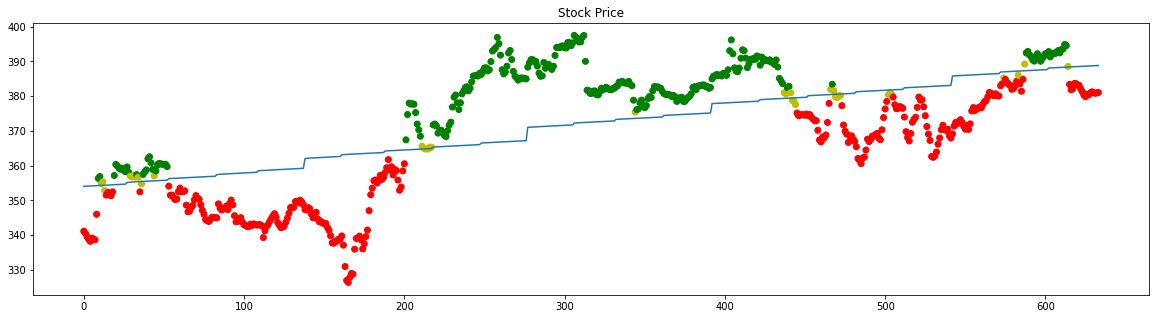

In [63]:
pred = lr3.predict(np.array(x).reshape(-1,1))
plt.figure(figsize = [20,5])

# x = data['pos'] # to separate out time between days
x = range(data.shape[0]) # smoothed out 
# y1 = data['Upper'].values
# y2 = data['Lower'].values
y1 = data['Midpoint'].values
pred = lr3.predict(np.array(data['pos']).reshape(-1,1))

# plt.scatter(x,y1,c='g')
# plt.scatter(x,y2,c='r')
plt.scatter(x,y1, c = epsilon_color)
plt.plot(x, pred)
plt.title('Stock Price')
plt.show()


In [64]:
tri_group = data[['MACD_category','RSI_category','Epsilon_category']].sum(axis = 1)
counter_dict = Counter(tri_group)

In [65]:
range_ = list(map(lambda x: 'C' + str(x), range(len(counter_dict))))
tri_dict = dict(zip(counter_dict.keys(), range_))
tri_color = list(map(lambda x: tri_dict[x], tri_group))

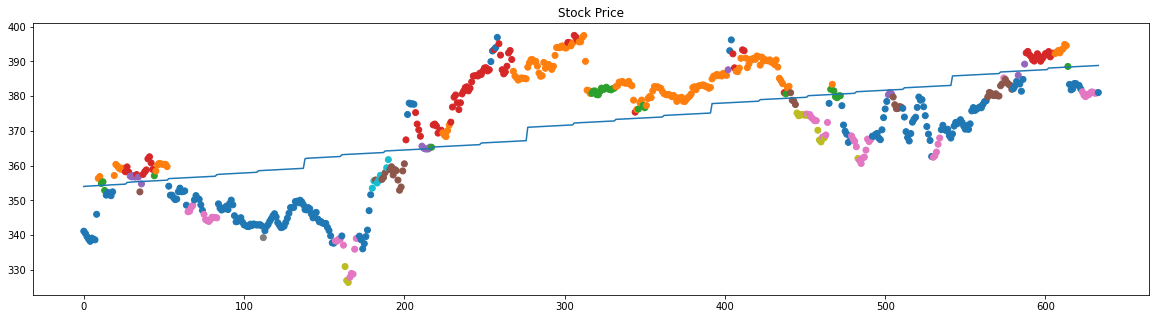

In [66]:
pred = lr3.predict(np.array(x).reshape(-1,1))
plt.figure(figsize = [20,5])

# x = data['pos'] # to separate out time between days
x = range(data.shape[0]) # smoothed out 
# y1 = data['Upper'].values
# y2 = data['Lower'].values
y1 = data['Midpoint'].values
pred = lr3.predict(np.array(data['pos']).reshape(-1,1))

# plt.scatter(x,y1,c='g')
# plt.scatter(x,y2,c='r')
plt.scatter(x,y1, c = tri_color)
plt.plot(x, pred)
plt.title('Stock Price')
plt.show()


## Bubble Pop Detection

In [67]:
## bubble pop detection

# initialize 
nbars = 14
x = data['pos'].values
y = data['Midpoint'].values
short_slope_list = []

# measure recent slopes
for i in range(nbars, len(vals)):
    xpart = x[(i-nbars):i].reshape(-1,1)
    ypart = y[(i-nbars):i].reshape(-1,1)
    _,m,_ = simple_lr(xpart, ypart)
    short_slope_list.append(m[0])

In [69]:
ss_list_mod = [0]*(data.shape[0] - len(short_slope_list)) + short_slope_list
ss_color = list(map(lambda x: 'g' if x >= m3 else 'r', ss_list_mod))

In [ ]:
tri_dict

In [73]:
data

,Datetime,Open,High,Low,Close,Adj Close,Volume,Upper,Lower,Midpoint,...,pos,prop_dist_1,epsilon,RSI,MACD,Signal Line,MACD Distance,MACD_category,RSI_category,Epsilon_category
0,2021-01-04 04:00:00-05:00,339.50,342.85,339.50,342.85,342.85,0,342.85,339.50,341.175,...,0.0,0.029831,-12.843482,NaN,NaN,NaN,NaN,normal,normal,low
1,2021-01-04 05:30:00-05:00,341.00,341.00,340.07,340.07,340.07,0,341.00,340.07,340.535,...,1.5,0.031863,-13.554477,NaN,NaN,NaN,NaN,normal,normal,low
2,2021-01-04 06:00:00-05:00,339.61,339.61,339.61,339.61,339.61,0,339.61,339.61,339.610,...,2.0,0.034564,-14.503142,NaN,NaN,NaN,NaN,normal,normal,low
3,2021-01-04 07:00:00-05:00,339.20,340.00,338.00,338.55,338.55,0,339.20,338.55,338.875,...,3.0,0.036794,-15.285472,NaN,NaN,NaN,NaN,normal,normal,low
4,2021-01-04 07:30:00-05:00,337.50,339.00,337.50,339.00,339.00,0,339.00,337.50,338.250,...,3.5,0.038641,-15.934137,NaN,NaN,NaN,NaN,normal,normal,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,2021-02-03 17:30:00-05:00,381.00,381.50,381.00,381.50,381.50,0,381.50,381.00,381.250,...,733.5,0.020993,-7.485117,39.943521,-2.264357,-2.080472,0.183885,low,normal,low
630,2021-02-03 18:00:00-05:00,381.00,381.50,380.00,381.00,381.00,0,381.00,381.00,381.000,...,734.0,0.021699,-7.758782,38.634370,-2.185079,-2.101393,0.083686,low,normal,low
631,2021-02-03 18:30:00-05:00,380.61,381.43,380.10,381.07,381.07,0,381.07,380.61,380.840,...,734.5,0.022175,-7.942447,38.936082,-2.092482,-2.099611,-0.007129,low,normal,low
632,2021-02-03 19:00:00-05:00,380.95,381.40,380.95,380.95,380.95,0,380.95,380.95,380.950,...,735.0,0.021957,-7.856112,38.585784,-2.005661,-2.080821,-0.075160,low,normal,low


macd rsi epsilon
['normalnormalnormal']


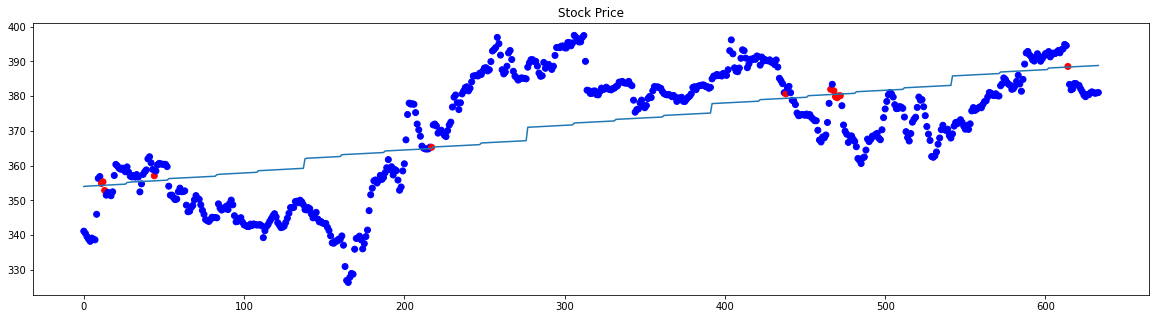

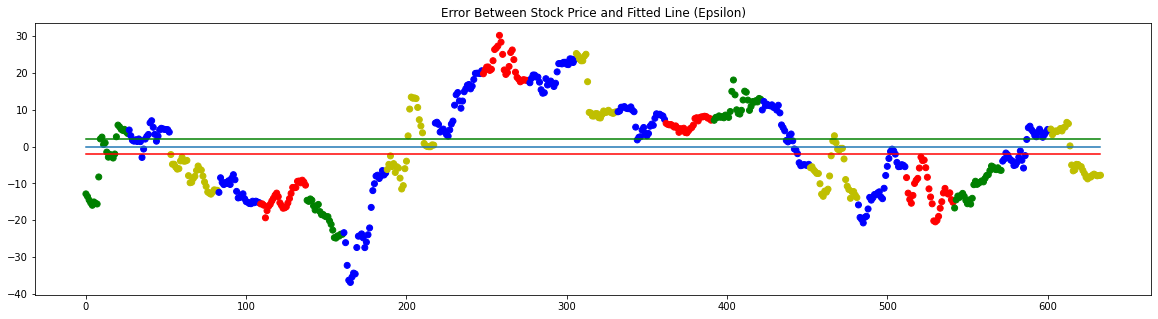

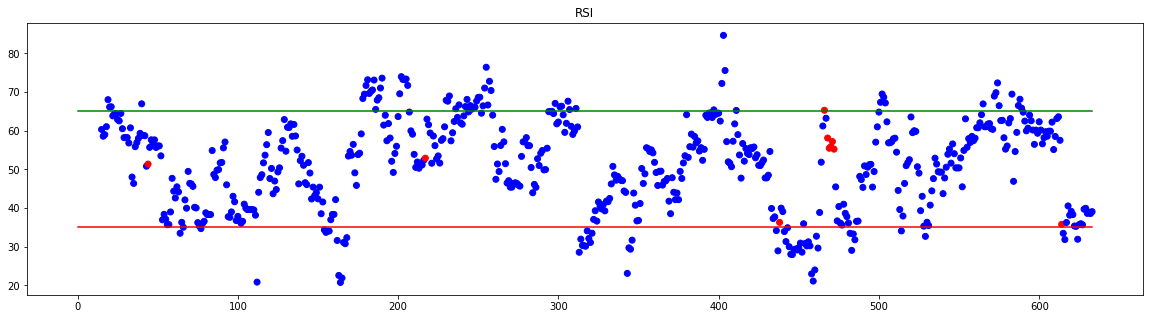

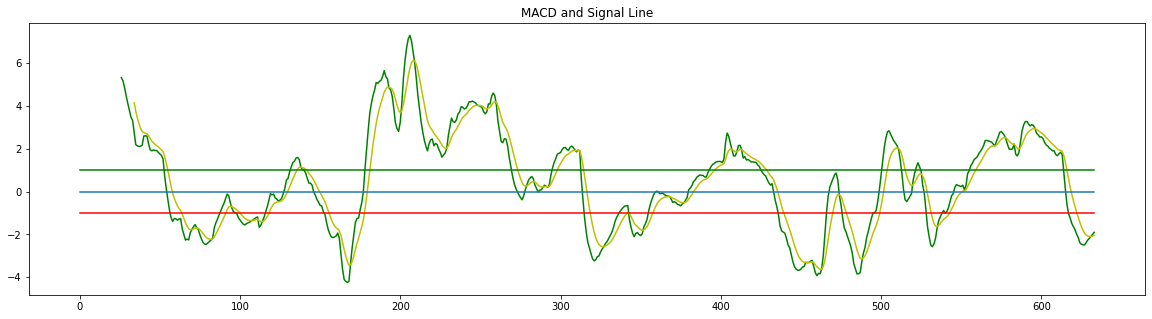

In [70]:
i = [2]
key_ = list(map(lambda x: list(tri_dict.keys())[x],i))
print('macd rsi epsilon')
print(key_)
tri_color = list(map(lambda x: 'r' if x in key_ else 'b', tri_group))

color_ = tri_color
pred = lr3.predict(np.array(x).reshape(-1,1))
l = 20; h = 5
plt.figure(figsize = [l,h])

# x = data['pos'] # to separate out time between days
x = range(data.shape[0]) # smoothed out 
# y1 = data['Upper'].values
# y2 = data['Lower'].values
y1 = data['Midpoint'].values
pred = lr3.predict(np.array(data['pos']).reshape(-1,1))

# plt.scatter(x,y1,c='g')
# plt.scatter(x,y2,c='r')
plt.scatter(x,y1, c = color_)
plt.plot(x, pred)
plt.title('Stock Price')
plt.show()

plt.figure(figsize = [l,h])
y = data['epsilon'].values
plt.scatter(x,y, c = weekdays)
plt.plot(x,[0]*len(x))
plt.plot(x,[2]*len(x),c='g')
plt.plot(x,[-2]*len(x),c='r')
plt.title('Error Between Stock Price and Fitted Line (Epsilon)')
plt.show()

plt.figure(figsize = [l,h])
y2 = data['RSI'].values
plt.scatter(x,y2, c = color_)
plt.plot(x,[65]*len(x), c='g')
plt.plot(x,[35]*len(x), c='r')
plt.title('RSI')
plt.show()

plt.figure(figsize = [l,h])
y3 = data['MACD'].values
y4 = data['Signal Line'].values
plt.plot(x,y3,c='g')
plt.plot(x,y4,c='y')
plt.plot(x,[0]*len(x))
plt.plot(x,[1]*len(x),c='g')
plt.plot(x,[-1]*len(x),c='r')
plt.title('MACD and Signal Line')
plt.show()